# Deep sequencing analysis for 65Q

# QC module

In [1]:
# Things that I look at:
# 1.	Using the spike-in reads, we infer cell to reads ratio, and try to make sure each sequence reads represent no more than 100 neoplastic.
# 2.	Check samples with an exceptionally high fraction of spike-in reads, which indicates unsuccessful PCR amplification of tumor DNA.
# 3.	Check the sequencing depth for each mouse sample and remove samples with less than 0.1 million reads.

# 4.	Check if all the sgRNAs are recovered in each sample.

# 5.	Check mice genotype mislabeling and check across mice contamination: Check the correlation of reads for each sgRNA-barcode combination between samples, samples from KT mice should have no correlation with others while reads from KTC mice should have weak correlations from other KTC mice.

# 6.	Check the correlation between total tumor burden for a given mouse and its lung weight. 

## 1 Functions and module

### 1.1 Modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import seaborn as sns
import regex

### 1.2 Functions

In [8]:
def Combine_DataFrame_Info(input_reads_df, input_gRNA_df, input_sample_df):
    # this function take reads, gRNA info df and sample df, and merge to a final data df
    # merge reads df with gRNA info df. Only gRNA match with reference will be selected
    temp_df = input_reads_df.merge(
        input_gRNA_df, how='inner', on=['gRNA'], sort=True)
    # merge reads df with sample info df
    output_df = temp_df.merge(
        input_sample_df, how='inner', on=['Sample_ID'], sort=True)
    output_df['gRNA_clonalbarcode'] = output_df['gRNA'] + '_' + output_df['Clonal_barcode']
    return (output_df)

In [9]:
def Generate_Raw_Dataframe(input_read_adress, input_gRNA_address, input_experiment_address,
                           barcode_pattern=False):
    # this function take three dataframe address, do some cleaning and combined them into one dataframe
    temp_c = ['gRNA', 'Clonal_barcode', 'Sample_ID', 'Count']
    combined_df = pd.read_csv(input_read_adress, index_col=0, header=None,
                              skiprows=[0,], names=temp_c)
    # Read gRNA and spike in info
    gRNA_info_df = pd.read_csv(input_gRNA_address, header=None, skiprows=[0,],
                               names=['Targeted_gene_name', 'gRNA'])
    # I drop duplicated gRNA information
    gRNA_info_df.drop_duplicates(inplace=True)
    # add identity to distinguish gRNA and spikein
    gRNA_info_df['Identity'] = gRNA_info_df.apply(
        lambda x: x['Targeted_gene_name'] if (
            'Spike' in x['Targeted_gene_name']) else 'gRNA', axis=1)
    # added number for sgRNAs for the same targeting gene
    gRNA_info_df['Numbered_gene_name'] = gRNA_info_df['Targeted_gene_name']
    mask = gRNA_info_df['Numbered_gene_name'].duplicated(keep=False)
    gRNA_info_df.loc[mask, 'Numbered_gene_name'] += '_'+gRNA_info_df.groupby(
        'Numbered_gene_name').cumcount().add(1).astype(str)
    # read experiment information
    exp_info_df = pd.read_csv(
        input_experiment_address)

    # rename column names to make it consistent
    exp_info_df.rename(columns = {'Sample ID':'Sample_ID','Mouse_Genotype':'Mouse_genotype',
                                 'Virus_Titer':'Virus_titer','Time_After_Tumor_Initiation(wks)':'Time_after_tumor_initiation',
                                 'Total_Lung_Weight(g)':'Total_lung_weight'}, inplace = True)
    Output_df = Combine_DataFrame_Info(combined_df,gRNA_info_df,exp_info_df)
    if barcode_pattern:
    # Now I check the barcode of gRNA to see if they are saturation barcode
    # temp_pattern = regex.compile('(.{3}A.{2}C.{4}C.{3})')
        temp_pattern = regex.compile(barcode_pattern)
        Output_df['Saturation_barcode'] = ['Spikein_barcode']*Output_df.shape[0]
        temp_list = []
        for temp_b in Output_df.loc[Output_df['Identity']=='gRNA','Clonal_barcode']:
            if temp_pattern.search(temp_b):
                temp_list.append('Real')
            else:
                temp_list.append('Fake')
        Output_df.loc[Output_df['Identity']=='gRNA', 'Saturation_barcode'] = temp_list
        Output_df = Output_df[Output_df['Saturation_barcode']!='Fake']
    print('There are totally {} reads'.format(combined_df['Count'].sum()))
    print('There are {} reads mapped to ref gRNA, which is about {}'.format(
        Output_df['Count'].sum(), Output_df ['Count'].sum()/combined_df['Count'].sum()))
    return (Output_df)

In [10]:
def Spikein_summary(input_df,input_spikein_name,input_cell_number):
# this function extract spike reads for each kind in each sample
    temp_df = input_df[input_df['Targeted_gene_name'].isin(input_spikein_name)] # select spike in rows
    temp_df = temp_df.groupby(['Sample_ID','Targeted_gene_name'],as_index = False).agg(
        Unique_spikein_barcode_number = pd.NamedAgg('Clonal_barcode',aggfunc = lambda x: len(x)), # number of different spike-in barcode
        Count = pd.NamedAgg('Count',aggfunc = np.sum)
    )
    temp_df['Cell_per_read'] = input_cell_number/temp_df['Count']
    temp_df['Amplification'] = temp_df.Count/temp_df.Unique_spikein_barcode_number
    return(temp_df)

In [11]:
# calculate the combined spikein metrics for each sample
def Cal_Spike_in_Ratio(x):
    d = {}
    temp_name_list = spikein_name_list # this is spike in name_list 
    temp_vect = x[['Targeted_gene_name','Count']]
    s1_value = x[x['Targeted_gene_name'] == temp_name_list[0]]['Count'].values[0]
    s2_value = x[x['Targeted_gene_name'] == temp_name_list[1]]['Count'].values[0]
    s3_value = x[x['Targeted_gene_name'] == temp_name_list[2]]['Count'].values[0]
    d['Spikein1'] = s1_value
    d['Spikein2'] = s2_value
    d['Spikein3'] = s3_value
    d['Mean_count'] = (s1_value+s2_value+s3_value)/3 # mean count for spike in 
    s1_s2_ratio =  s1_value/s2_value# spikein 1/ spikein 2 ratio
    s1_s3_ratio =  s1_value/s3_value# spikein 1/ spikein 2 ratio
    d['s1_s2_ratio'] = s1_s2_ratio
    d['s1_s3_ratio'] = s1_s3_ratio
    d['max_least_ratio'] = sorted([s1_value,s2_value,s3_value])[-1]/sorted([s1_value,s2_value,s3_value])[0]
    return pd.Series(d, index=list(d.keys())) 

In [12]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size = 6)

In [13]:
def Generate_Simple_Sample_Summary(input_df,input_spikein_df):
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_genotype','Virus_titer','Total_lung_weight','Mouse_Ear_Tag'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum)) # total reads
    spikein_name_list = ['tuba-seq-v2_Spike-in-1','tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'] # spike in name should be ordered here
    temp_spike_df = input_spikein_df.set_index('Sample_ID')
    temp_df0['Spike1_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[0]].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike2_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[1]].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike3_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[2]].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    return(temp_df0)

In [14]:
def Generate_Conversion_factor(input_spike_df, input_candidate_list, input_spike_in_list,temp_spikein_cell_number):
    # this function generate a df storing cell number per reads
    # input_spike_df is the df contain the spikein information (spikein_ratio_df)
    # temp_spikein_cell_number is the cell number for each spike in added into sample (usually it is 100K)
    # for most sample, I will use temp_spikein_cell_number/ mean(spike in reads)
    # input_candidate_list is the list of sample id whose spikein needed special treatment
    # temp_spikein_cell_number specify which spike in will be use for each sample ID who need special treatment
    input_dic = dict(zip(input_candidate_list, input_spike_in_list))
    temp_dic = {}
    for index,row in input_spike_df.iterrows():
        temp_id = row['Sample_ID']
        if temp_id in input_dic.keys():
            # print(row[input_dic.get(id)])
            temp_value = row[input_dic.get(temp_id)].mean()
        else:
            temp_value = row['Mean_count']
        temp_dic[temp_id] = temp_spikein_cell_number/temp_value
    temp_df = pd.DataFrame({'Sample_ID':temp_dic.keys(),
                       'Cell_number_per_read':temp_dic.values()})
    temp_df['Correction_for_spikein'] = temp_df['Sample_ID'].apply(lambda x: 'Yes' if (x in input_candidate_list) else 'No')
    return(temp_df)
        

In [15]:
def Final_df_Generation(input_df,input_conversion_factor_df):
    # input_df is the dataframe input
    # input_conversion_factor_df is the dictionary that store the the cell number per reads
    temp_df = input_df.merge(input_conversion_factor_df, on ='Sample_ID')
    temp_df['Cell_number'] = temp_df['Count']*temp_df['Cell_number_per_read']
    return(temp_df)

In [16]:
# calculate the summary metrics for each sample
def Cal_Sample_Summary(x):
    d = {}
    temp_vect = x['Cell_number']
    if type (temp_vect) == 'int':
        temp_vect = [temp_vect]
    d['gRNA_recovered'] = len(x['gRNA'].unique())
    d['TTB'] = sum(temp_vect) # total mutational burdern 
    d['TTN'] = len(temp_vect) # this is total tumor number
    return pd.Series(d, index=list(d.keys())) 

In [17]:
def Generate_Sample_Summary(input_df, input_spikein_check_df,input_cell_number_cutoff,input_read_cutoff):
    # input_cell_number_cutoff is the cell number cutoff
    # input_rad_cutoff is the read cutoff
    # Total reads does not restricted to gRNA or cell number cutoff
    
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_Ear_Tag','Mouse_genotype', 'Sex',
         'Time_after_tumor_initiation', 'Total_lung_weight', 'Virus_titer','Correction_for_spikein','Cell_number_per_read'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum))
    temp_df0 = temp_df0.merge(input_spikein_check_df[['Sample_ID','Mean_count','max_least_ratio']],on = 'Sample_ID') # merge spike in info
    temp_df0['Spikein_read_ratio'] = (temp_df0['Mean_count']*3)/temp_df0['TTR']
    # filter input data
    temp_input = input_df[(input_df['Cell_number']>=input_cell_number_cutoff)&(input_df['Count']>input_read_cutoff)]
    # I only consider non-spikein gRNA
    temp_df1 = temp_input[temp_input['Identity']=='gRNA'].groupby(
        ['Sample_ID'],as_index = False).apply(
        Cal_Sample_Summary)
    temp_df1['TTB_million'] = temp_df1['TTB']/1000000
    # merge sample and gRNA information    
    temp_df1 = temp_df1.merge(temp_df0,on = 'Sample_ID',how = 'right')
    return(temp_df1)

In [18]:
def Plot_Correlation_Plot_V2_P(input_df,unit_name, trait_of_interest,input_method,color,output_address):
    # cluster with indicator bar of sex and genotype
    temp_cor_matrix = Generate_DF_for_Correlation(input_df,unit_name,trait_of_interest).corr(method=input_method, min_periods=1)
    myvar = pd.Series(temp_cor_matrix.columns)
    tt = input_df[['Sample_ID','Sex','Mouse_genotype']].drop_duplicates()
    temp_dict_row = dict(zip(tt.Sample_ID, tt.Sex))
    temp_dict_col = dict(zip(tt.Sample_ID, tt.Mouse_genotype))
    row_color_list = myvar.map(temp_dict_row).map({'F':'r','M':'g'})
    col_color_list = myvar.map(temp_dict_col).map({'KT':'k','KTC':'b'})
    mask = temp_cor_matrix.isnull()
    g = sns.clustermap(temp_cor_matrix, row_colors=row_color_list.values,
                       col_colors=col_color_list.values,mask = mask, cmap=color,xticklabels=True, yticklabels=True)
    g.fig.suptitle('Correlation of {} for {} across samples'.format(trait_of_interest,unit_name)) 
    if output_address:
        g.savefig(output_address)

In [19]:
def Generate_DF_for_Correlation(input_df, unit_name, trait_of_interest):
    temp_name_list = input_df['Sample_ID'].unique()
    temp_column_list = [unit_name,trait_of_interest]

    temp_1 = input_df[input_df['Sample_ID'] == temp_name_list[0]][temp_column_list]
    temp_1.rename(columns={trait_of_interest:temp_name_list[0]}, inplace=True)
    for x in temp_name_list[1:]:
        temp_2 = input_df[input_df['Sample_ID'] == x][temp_column_list]
        temp_2.rename(columns={trait_of_interest:x}, inplace=True)
        temp_1 = temp_1.merge(temp_2,on=unit_name,how = 'outer')
    return(temp_1)

----

## 2 Input and output address

In [20]:
# combined barcode dataframe address
parent_address = "Data/Chromatin_65Q/"
combined_df_address = parent_address + "gRNA_clonalbarcode_combined_65Q_deepseq.csv"
# gRNA information address
gRNA_info_address = parent_address + "gRNA_information.csv"
# experimental information address
exp_info_address = parent_address + "65Q_information_standardized.csv"

In [21]:
figure_output_address = "Figure/Chromatin_65Q/"
Final_df_output_address = parent_address + "65Q_final_df.csv"
sample_summary_address = parent_address + "65Q_sample_summary_df.csv"
sample_discarded_list_address = parent_address + "Discarded_sample_list_for_65Q.txt"

-----

## 3 Raw data processing

### 3.1 Explaination and note
* <font size="5"> 3.2 only gRNAs matched to existing gRNA or spike in are retained</font>
* <font size="5"> 3.3 I want to know if any spikein has unexpected high or low read in certain sample</font>
* <font size="5"> 3.2 I only consider barcode pattern that matched the Jackie ID pattern</font>

### 3.2 raw data Generation

In [22]:
raw_summary_df = Generate_Raw_Dataframe(combined_df_address, gRNA_info_address, exp_info_address)

There are totally 151776597 reads
There are 144841985 reads mapped to ref gRNA, which is about 0.9543104000414504


## 4 Spikein QC

### 4.1 Count spikein read numbers and ratio

In [23]:
# I first check if spikes have similar read counts 
spikein_name_list = ['tuba-seq-v2_Spike-in-1','tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'] # spike in name should be ordered here
spikein_df = Spikein_summary(raw_summary_df,spikein_name_list,100000)

In [24]:
spikein_df.head()

,Sample_ID,Targeted_gene_name,Unique_spikein_barcode_number,Count,Cell_per_read,Amplification
0,LA55_01,tuba-seq-v2_Spike-in-1,251,1725,57.971014,6.872510
1,LA55_01,tuba-seq-v2_Spike-in-2,246,1448,69.060773,5.886179
2,LA55_01,tuba-seq-v2_Spike-in-3,194,1140,87.719298,5.876289
3,LA55_02,tuba-seq-v2_Spike-in-1,265,1372,72.886297,5.177358
4,LA55_02,tuba-seq-v2_Spike-in-2,287,1451,68.917988,5.055749


In [25]:
spikein_ratio_df = spikein_df.groupby(['Sample_ID'],as_index = False).apply(Cal_Spike_in_Ratio) # the ratio of spike in

In [26]:
spikein_ratio_df.head()

,Sample_ID,Spikein1,Spikein2,Spikein3,Mean_count,s1_s2_ratio,s1_s3_ratio,max_least_ratio
0,LA55_01,1725.0,1448.0,1140.0,1437.666667,1.191298,1.513158,1.513158
1,LA55_02,1372.0,1451.0,1392.0,1405.000000,0.945555,0.985632,1.057580
2,LA55_03,1687.0,1804.0,1349.0,1613.333333,0.935144,1.250556,1.337287
3,LA55_04,2147.0,2028.0,1767.0,1980.666667,1.058679,1.215054,1.215054
4,LA55_05,3533.0,2970.0,2384.0,2962.333333,1.189562,1.481963,1.481963


### 4.2 Find samples with unusual spike in ratio

Text(0, 0.5, 's1/s3')

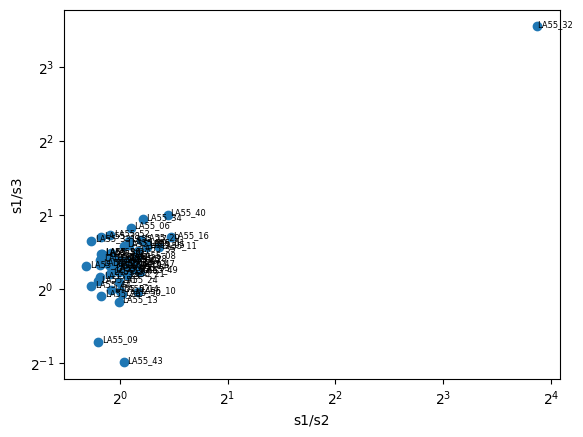

In [27]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
plt.xscale('log',base = 2)
plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

* <font size="5" color =  red> For the sample <mark>A55_32</mark>, the spike-in are looks strange</font>

### 4.3 Find bad spike-in for those samples

#### 4.3.1 Method 1

* <font size="5" color =  red> The three spike-ins are assummed to be equal amount, so I try to find samples with distorted spike-in ratio</font>

In [28]:
input_ratio_cutoff = 3 # this is the cutoff 
temp_bad_list = spikein_ratio_df.loc[spikein_ratio_df['max_least_ratio']>input_ratio_cutoff,'Sample_ID'].to_list() # list of sample with bad spikein

/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_15351/1708176043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])


Text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>3)')

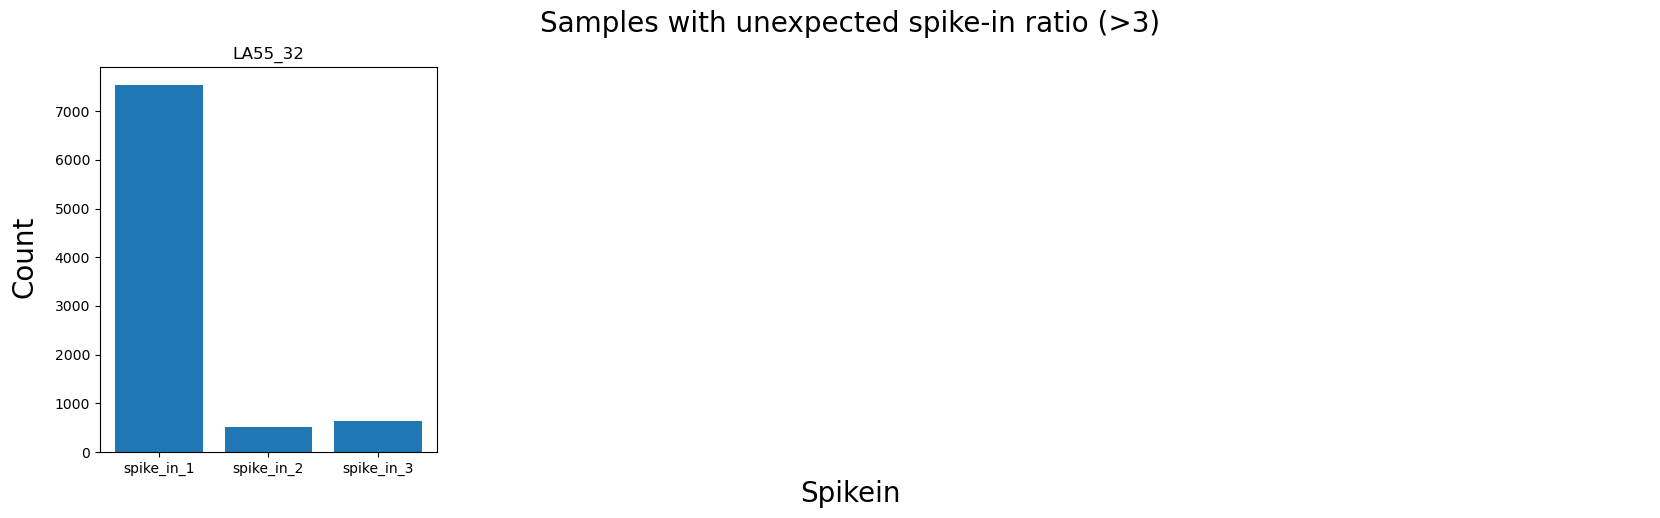

In [29]:
# check the max/min ratio in each sample and print those sample with ratio above certain cutoff
fig1,ax = plt.subplots(math.ceil(len(temp_bad_list)/4), 4, figsize=(20,5*math.ceil(len(temp_bad_list)/4)))
axes = ax.flatten()
for x,y in zip(axes[:len(temp_bad_list)],temp_bad_list):
    temp_df = spikein_df[spikein_df['Sample_ID'] == y]
    x.bar(temp_df['Targeted_gene_name'],temp_df['Count'])
    x.set_title(y)
    x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])
for x in axes[len(temp_bad_list):]:
    x.set_axis_off()
fig1.text(0.08, 0.5, 'Count', va='center', rotation='vertical',fontsize=20)
fig1.text(0.5, 0.01, 'Spikein', ha='center',fontsize=20)
fig1.text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>{})'.format(input_ratio_cutoff), ha='center',fontsize=20)
# fig1.savefig(figure_output_address+'QC_332.pdf')aa

* <font size="5" color =  black> If we assume only one of the spikein has a problem, the one with extraordinary <mark> high </mark> count seems to be the problematic one</font>

#### 4.3.2 Method 2

In [30]:
temp_summary_df = Generate_Simple_Sample_Summary(raw_summary_df,spikein_df)

In [31]:
temp_summary_df.head()

,Sample_ID,Mouse_genotype,Virus_titer,Total_lung_weight,Mouse_Ear_Tag,TTR,Spike1_reads_fraction,Spike2_reads_fraction,Spike3_reads_fraction
0,LA55_01,KTC,130K,0.9595,1791,2310073,0.000747,0.000627,0.000493
1,LA55_02,KTC,130K,1.0160,1788,1970145,0.000696,0.000736,0.000707
2,LA55_03,KTC,130K,0.9915,1790,1741485,0.000969,0.001036,0.000775
3,LA55_04,KTC,130K,1.0216,1806,2036735,0.001054,0.000996,0.000868
4,LA55_05,KTC,130K,0.7873,1807,3693046,0.000957,0.000804,0.000646


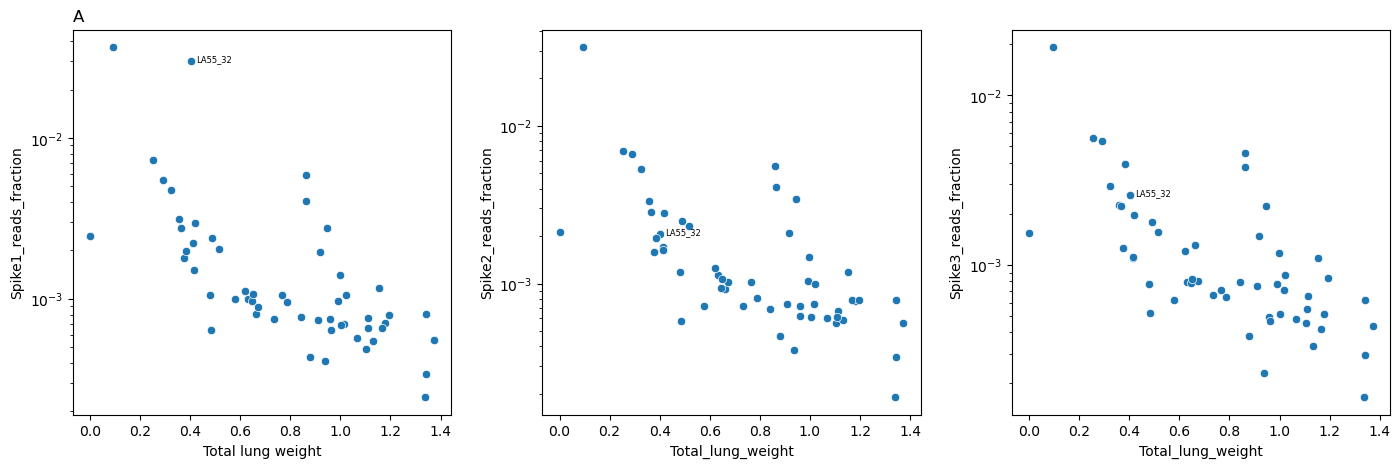

In [32]:
gs = gridspec.GridSpec(1, 17) 
fig1 = plt.figure(figsize=(17,5))

ax1=fig1.add_subplot(gs[:1, 0:5])
temp_df = temp_summary_df
ix = 'Total_lung_weight'
iy = 'Spike1_reads_fraction'
sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax1)
temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
label_point(temp_sub[ix],temp_sub[iy], temp_sub['Sample_ID'], plt.gca())


ax1.set_xlabel('Total lung weight')
ax1.set_ylabel(iy)
ax1.set_yscale('log')
ax1.set_title('A', loc ='left')


ax2=fig1.add_subplot(gs[:1, 6:11])
temp_df = temp_summary_df
ix = 'Total_lung_weight'
iy = 'Spike2_reads_fraction'
sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax2)
temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
label_point(temp_sub[ix],temp_sub[iy], temp_sub['Sample_ID'], plt.gca())

ax2.set_yscale('log')
# ax2.set_xlabel('Total lung weight')
# ax2.set_ylabel('Total tumor burden (million cells)')
# ax2.set_title('B', loc ='Left')


ax3 = fig1.add_subplot(gs[:1, 12:17])
temp_df = temp_summary_df
ix = 'Total_lung_weight'
iy = 'Spike3_reads_fraction'
sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax3)
temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
label_point(temp_sub[ix],temp_sub[iy], temp_sub['Sample_ID'], plt.gca())

ax3.set_yscale('log')

* <font size="5" color =  black> I will use spikein2 and spikein3 for LA55_32 </font>

## 5 Correct Cell per reads

* <font size="5" color =  red> For each sample I generate a conversion factor, which is cell number per reads</font>

In [33]:
temp_bad_list

['LA55_32']

In [34]:
temp = [['Spikein2','Spikein3']]
conversion_factor_df= Generate_Conversion_factor(spikein_ratio_df,temp_bad_list,temp,100000)

In [35]:
conversion_factor_df.head()

,Sample_ID,Cell_number_per_read,Correction_for_spikein
0,LA55_01,69.557153,No
1,LA55_02,71.174377,No
2,LA55_03,61.983471,No
3,LA55_04,50.488051,No
4,LA55_05,33.757173,No


In [36]:
Final_df = Final_df_Generation(raw_summary_df,conversion_factor_df)

In [37]:
Final_df.to_csv(Final_df_output_address,index=False)

## 6 Overall sample QC 

### 6.1 Explaination

In [38]:
cell_number_cutoff = 300
Sample_summary_df = Generate_Sample_Summary(Final_df, spikein_ratio_df,cell_number_cutoff,3)

* <font size="5"> I have cutoff for both cell number and read number</font>
* <font size="5"> $N_{sgTG_i,S_j}$ Stands for cell number of sgRNAi targeting a certain gene in mouse sample Sj</font>
* <font size="5"> $TTB_{S_j}$ stands for total tumor burden for a sample Sj </font>
* <font size="5"> $TTB_{S_j}=\sum_{i=1}^{n_{S_j}}N_{sgTG_i,S_j}$ </font>
* <font size="5"> When calculating $TTB_{S_j}$, I can also set a cutoff for a minimal cell number to be considered as real epithelial cells </font>

### 6.2 Plot

* <font size="5" color =  red> For panel A, I just want to show the how many cells each sequencing read represent</font>
* <font size="5" color =  blue> For panel B, most of the dots show positive correlation between tumor burden and tumor weight.</font>
* <font size="5" color =  green> For panel C, same as panel B. Here I just want to check if any spike in corrected sample will deviate from the line. Because if the spike-in reads are wrong, they will not follow the general trend</font>

* <font size="5" color =  brown> For panel D, I want to show the spikein ratio and total number of reads mapped to each sample. Three sample has very weird spikein ratio</font>

* <font size="5" color =  orange> For panel E, I want to show the number of gRNA recovered.</font>
* <font size="5" color =  purple> For panel F, I want to check if there is saturation of tumor burden with the increasing of more tumor.</font>

* <font size="5" color =  oliva> For panel G, I want to show the relation between virus titer and TTB.</font>

* <font size="5" color =  oliva> For panel H, I want to show the relation between virus titer and TTN.</font>

Text(0, 0.5, 'Total tumor number)')

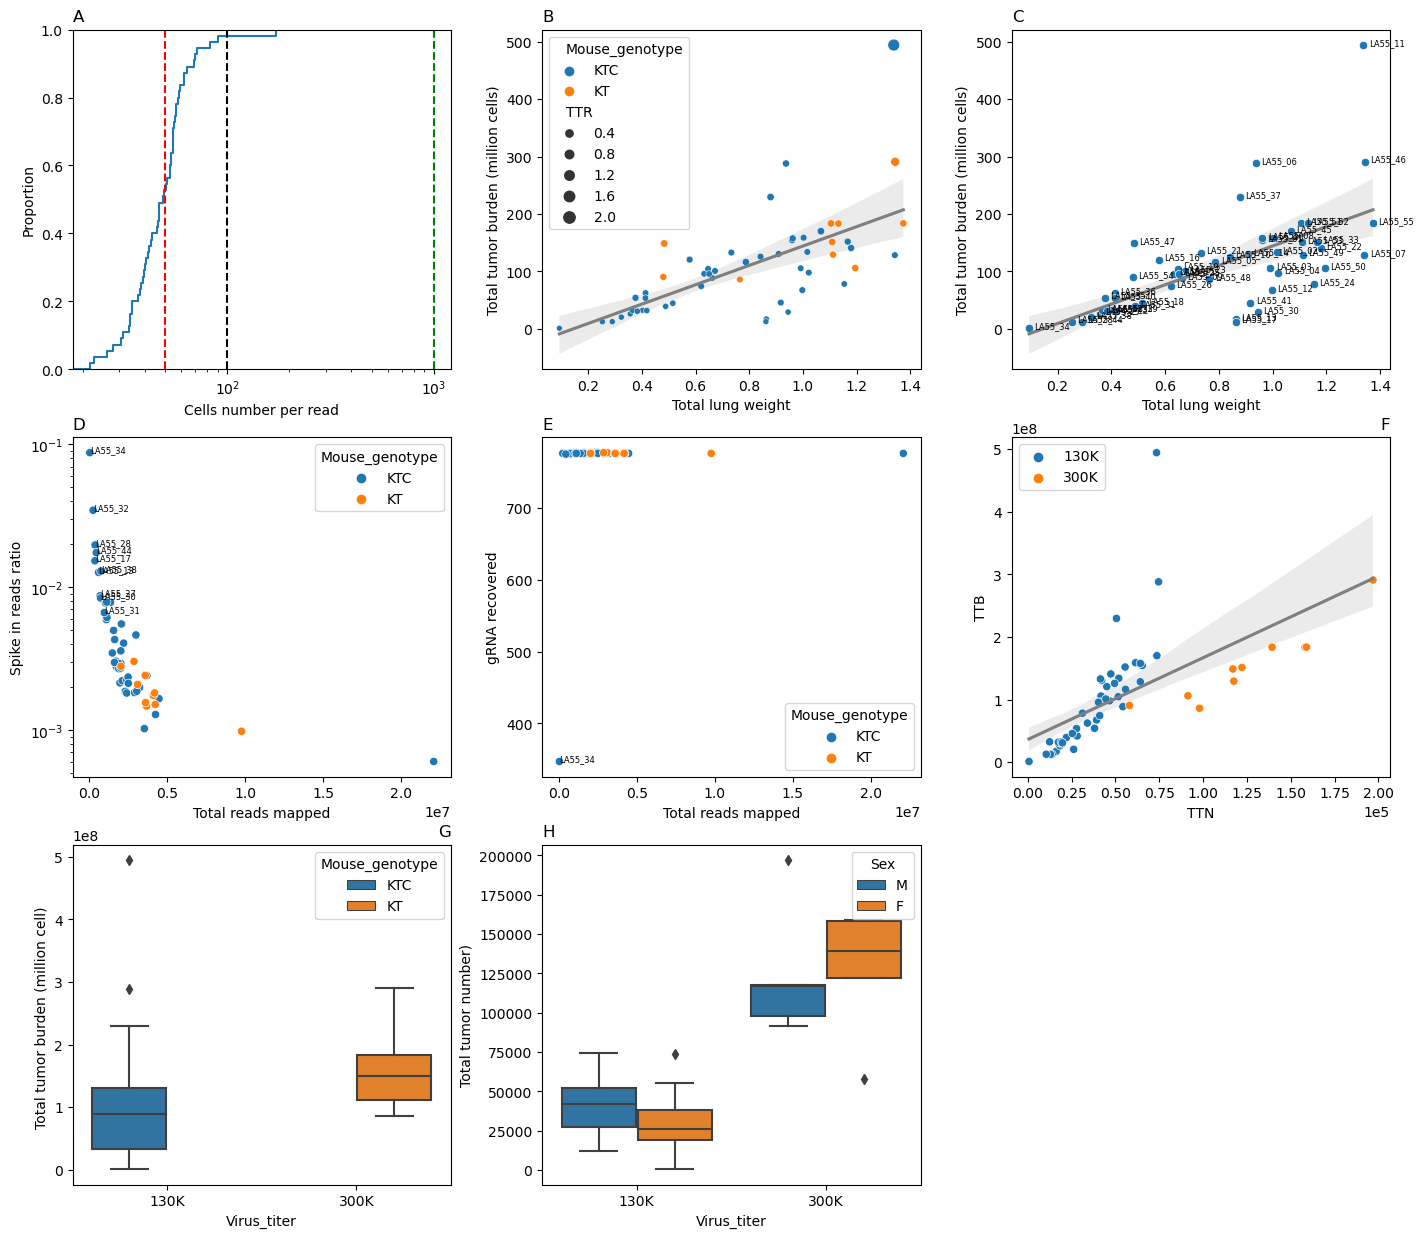

In [39]:
gs = gridspec.GridSpec(3, 17) 
fig1 = plt.figure(figsize=(17,15))

ax1=fig1.add_subplot(gs[:1, 0:5])
temp_df = Sample_summary_df
sns.ecdfplot(data=temp_df, x="Cell_number_per_read",ax = ax1)
ax1.set_xlabel('Cells number per read')
ax1.set_xscale('log')
ax1.axvline(50,color='red', linestyle='--')
ax1.axvline(100,color='black', linestyle='--')
ax1.axvline(1000,color='green', linestyle='--')
ax1.set_title('A', loc ='left')


ax2=fig1.add_subplot(gs[:1, 6:11])
temp_df = Sample_summary_df[(Sample_summary_df['Total_lung_weight']!= 0)&(~Sample_summary_df['TTB_million'].isna())]
sns.regplot(x='Total_lung_weight', y='TTB_million', data=temp_df, fit_reg=True ,ax= ax2,scatter=False,color = 'tab:grey')
sns.scatterplot(x='Total_lung_weight', y='TTB_million', data=temp_df, hue = 'Mouse_genotype',ax = ax2,size= 'TTR')
# label_point(temp_df['Total_lung_weight'], temp_df['TTB_million'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax2.set_xlabel('Total lung weight')
ax2.set_ylabel('Total tumor burden (million cells)')
ax2.set_title('B', loc ='Left')

ax3=fig1.add_subplot(gs[:1, 12:17])
sns.regplot(x='Total_lung_weight', y='TTB_million', data=temp_df, fit_reg=True ,ax= ax3,scatter=False,color = 'tab:grey')
sns.scatterplot(x='Total_lung_weight', y='TTB_million', data=temp_df, ax = ax3)
label_point(temp_df['Total_lung_weight'], temp_df['TTB_million'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax3.set_xlabel('Total lung weight')
ax3.set_ylabel('Total tumor burden (million cells)')
ax3.set_title('C', loc ='Left')


ax4 = fig1.add_subplot(gs[1:2, 0:5])
sns.scatterplot(x='TTR', y='Spikein_read_ratio', data=Sample_summary_df, hue='Mouse_genotype', ax= ax4)
temp_df = Sample_summary_df[Sample_summary_df.TTR<1000000] # < 1 million reads
label_point(temp_df['TTR'], temp_df['Spikein_read_ratio'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax4.set_yscale('log')
ax4.set_title('D', loc ='Left')
ax4.set_xlabel('Total reads mapped')
ax4.set_ylabel('Spike in reads ratio')

    
ax5 = fig1.add_subplot(gs[1:2, 6:11])

sns.scatterplot(x='TTR', y='gRNA_recovered',data=Sample_summary_df,hue='Mouse_genotype', ax= ax5)

temp_df = Sample_summary_df[Sample_summary_df.gRNA_recovered<770] # 
label_point(temp_df['TTR'], temp_df['gRNA_recovered'], temp_df['Sample_ID'], plt.gca()) # this is for labeling

ax5.set_xlabel('Total reads mapped')
ax5.set_ylabel('gRNA recovered')
ax5.set_title('E', loc ='left')


temp_df = Sample_summary_df[Sample_summary_df.TTR>0] # I request at least 1 million reads
ax6 = fig1.add_subplot(gs[1:2, 12:17])
sns.regplot(x='TTN', y='TTB', data=temp_df, fit_reg=True ,ax= ax6,scatter=False,color = 'tab:grey')
sns.scatterplot(x='TTN', y='TTB', data=temp_df, hue='Virus_titer', ax= ax6)
# ax6.set_yscale('log')
ax6.set_title('F', loc ='Right')
ax6.set_xlabel('TTN')
ax6.set_ylabel('TTB')
# ax6.xaxis.major.formatter._useMathText = True
ax6.ticklabel_format(axis='both',style='sci',scilimits=(-3,4))
ax6.legend(loc='upper left')


ax7 = fig1.add_subplot(gs[2:3, :5])
sns.boxplot(x='Virus_titer', y='TTB', data=Sample_summary_df, hue='Mouse_genotype', ax= ax7)
ax7.set_title('G', loc ='right')
ax7.set_ylabel('Total tumor burden (million cell) ')

ax8 = fig1.add_subplot(gs[2:3, 6:11])
sns.boxplot(x='Virus_titer', y='TTN', data=Sample_summary_df, hue='Sex', ax= ax8)
ax8.set_title('H', loc ='Left')
ax8.set_ylabel('Total tumor number)')
# fig1.savefig(figure_output_address+'QC_Plot.pdf')

In [40]:
Sample_summary_df.sort_values(by = 'TTR').head()

,Sample_ID,gRNA_recovered,TTB,TTN,TTB_million,Mouse_Ear_Tag,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio
33,LA55_34,347.0,1.161702e+06,661.0,1.161702,1940,KTC,F,15 wks,0.0933,130K,No,89.901109,38085,1112.333333,1.913934,0.087620
31,LA55_32,776.0,3.257829e+07,12417.0,32.578295,LA524,KTC,M,15 wks,0.4027,130K,Yes,172.265289,251034,2897.666667,14.625243,0.034629
16,LA55_17,776.0,1.276897e+07,13779.0,12.768970,1895,KTC,M,15 wks,0.8620,130K,No,53.285968,367349,1876.666667,1.567218,0.015326
27,LA55_28,776.0,1.248557e+07,12917.0,12.485575,LA512,KTC,M,15 wks,0.2532,130K,No,40.106952,378515,2493.333333,1.295005,0.019761
43,LA55_44,775.0,1.272457e+07,10490.0,12.724566,LA529,KTC,F,15 wks,0.2900,130K,No,38.046925,450773,2628.333333,1.230198,0.017492


#### Output

In [41]:
Sample_summary_df.to_csv(sample_summary_address, index = False)

### Conclusion

* <font size="5" color =  red> I will throw away sample LA55_34,because it is just having too few reads, and most of them are spike in.</font>
* <font size="5" color =  red> As usual in panel H, the male always has a higher TTN than the female.</font>
* <font size="5" color =  red> Sample with a hard cutoff of 0.1 M reads</font>

In [42]:
Sample_to_throw = ['LA55_34']

## 7 Correlation

### 7.1 Without cell number cutoff

In [43]:
temp_df.head()

,Sample_ID,gRNA_recovered,TTB,TTN,TTB_million,Mouse_Ear_Tag,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio
0,LA55_01,777.0,1.544288e+08,65276.0,154.428843,1791,KTC,M,15 wks,0.9595,130K,No,69.557153,2310073,1437.666667,1.513158,0.001867
1,LA55_02,776.0,1.340418e+08,51887.0,134.041779,1788,KTC,M,15 wks,1.0160,130K,No,71.174377,1970145,1405.000000,1.057580,0.002139
2,LA55_03,776.0,1.056733e+08,41756.0,105.673264,1790,KTC,M,15 wks,0.9915,130K,No,61.983471,1741485,1613.333333,1.337287,0.002779
3,LA55_04,776.0,9.804729e+07,46616.0,98.047290,1806,KTC,M,15 wks,1.0216,130K,No,50.488051,2036735,1980.666667,1.215054,0.002917
4,LA55_05,776.0,1.164301e+08,55730.0,116.430111,1807,KTC,M,15 wks,0.7873,130K,No,33.757173,3693046,2962.333333,1.481963,0.002406


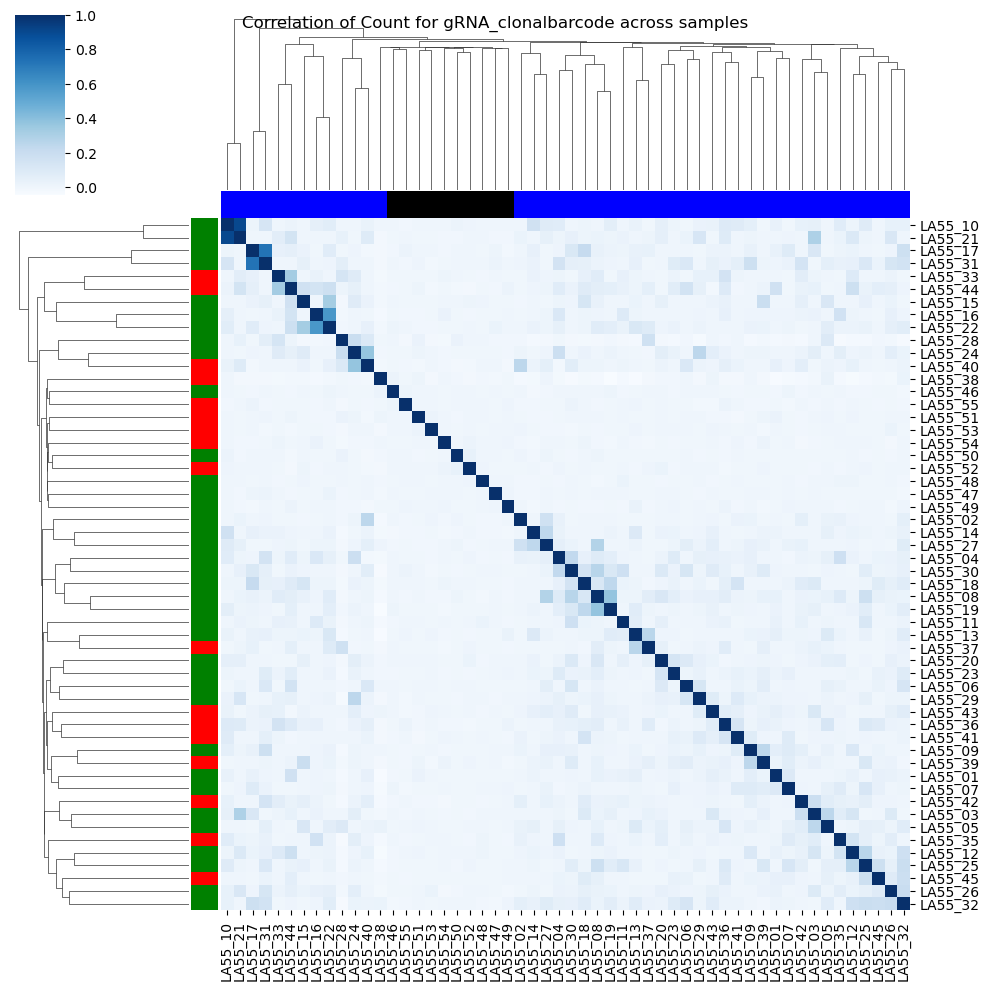

In [44]:
# temp_df = raw_summary_df[(raw_summary_df['Identity']=='gRNA')]
temp_df = Final_df[(Final_df['Identity']=='gRNA')&(~Final_df.Sample_ID.isin(Sample_to_throw))]
# Plot_Correlation_Plot_V2_P(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",figure_output_address+'SSA_3511.pdf')
Plot_Correlation_Plot_V2_P(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",False)

### 7.2 With cell number cutoff

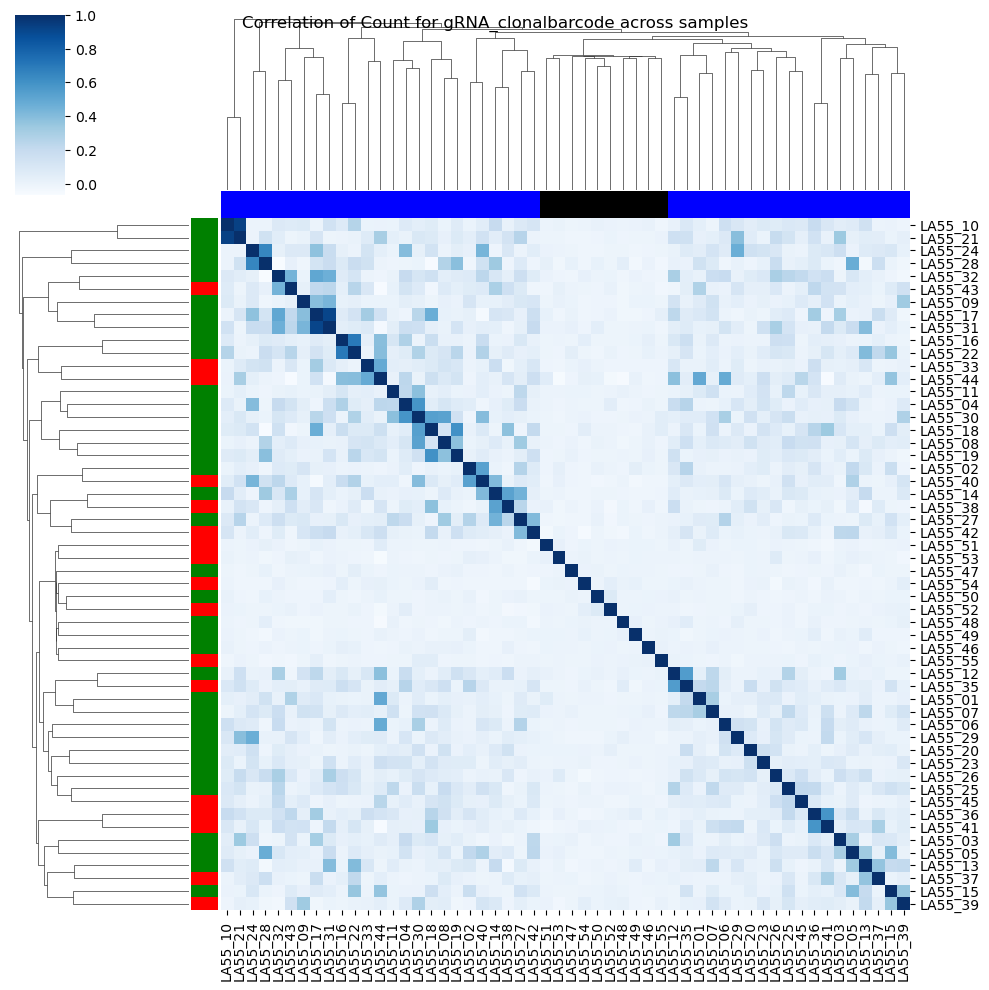

In [45]:
# temp_df = raw_summary_df[(raw_summary_df['Identity']=='gRNA')]
temp_df = Final_df[(Final_df['Identity']=='gRNA')&(~Final_df.Sample_ID.isin(Sample_to_throw))&(Final_df.Cell_number>300)]
# Plot_Correlation_Plot_V2_P(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",figure_output_address+'SSA_3511.pdf')
Plot_Correlation_Plot_V2_P(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",False)

* <font size="5" color =  red> I will not through any mice based thes results. They are very clean</font>

In [46]:
Final_Sample_to_throw = Sample_to_throw + []

In [47]:
Final_Sample_to_throw

['LA55_34']

In [48]:
with open(sample_discarded_list_address,'w') as handler:
    for x in Final_Sample_to_throw:
        handler.write(x+'\n')